# PEEP Offline RL Agent — v4
**Key changes from v3:**
- Reward normalisation (zero mean, unit variance) — fixes Q overestimation root cause
- CQL weight increased 0.5 → 2.0 — forces conservative Q-estimates that align with PDIS
- Hard Q-value clipping to physically meaningful range
- BC weight reduced to 0.1 (fixed, no anneal) — less imitation, more conservatism
- PDIS diagnostic: prints raw weight stats so you can see if clipping is too tight/loose
- Subgroup PDIS: runs clipped PDIS separately per DP severity group

In [1]:
import os, random, torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Status: Running on {DEVICE}")


Status: Running on mps


In [2]:
# =========================================================
# CELL 2: Data Loading & Preprocessing  (unchanged from v3)
# =========================================================
df = pd.read_csv("/Users/aryanb/aryan personal/code/datathon26/rl/data/data_v3_max_72_h.csv")
df["measure_time"] = pd.to_numeric(df["measure_time"], errors="coerce")
df = df.dropna(subset=["visit_occurrence_id","measure_time"]).copy()
df = df.sort_values(["visit_occurrence_id","measure_time"]).reset_index(drop=True)

VENT = [c for c in ["peep_median","peak_median"] if c in df.columns]
PHYS = [c for c in ["map_median","sbp_median","dbp_median","temp_median","wbc_median",
        "hemoglobin_median","platelets_median","sodium_median","potassium_median",
        "chloride_median","glucose_median","bun_median","creatinine_median","crp_median"]
        if c in df.columns]
OXY  = [c for c in ["spo2_median","fio2_median","pao2_median","paco2_median","ph_median"]
        if c in df.columns]
RESP = [c for c in ["tidal_volume_median","respiratory_rate_median","compliance_median"]
        if c in df.columns]
ALL_CONT = VENT + PHYS + OXY + RESP

for c in ALL_CONT:
    df[f"{c}_missing"] = df[c].isna().astype(int)
df[ALL_CONT] = df.groupby("visit_occurrence_id")[ALL_CONT].ffill()

df["dp_dyn"]     = df["peak_median"] - df["peep_median"]
df["peep_t"]     = df["peep_median"]
df["delta_peep"] = df.groupby("visit_occurrence_id")["peep_t"].diff().fillna(0.0).round(2)

if "pao2_median" in df.columns and "fio2_median" in df.columns:
    df["pf_ratio"] = df["pao2_median"] / (df["fio2_median"].replace(0, np.nan) / 100.0)
if "tidal_volume_median" in df.columns:
    df["compliance"] = df["tidal_volume_median"] / df["dp_dyn"].replace(0, np.nan)

trend_src = (["dp_dyn","peep_t"] +
             (["pf_ratio"]   if "pf_ratio"   in df.columns else []) +
             (["map_median"] if "map_median" in df.columns else []) +
             (["spo2_median"] if "spo2_median" in df.columns else []))
for col in trend_src:
    for w in [3, 6]:
        rolled = df.groupby("visit_occurrence_id")[col].transform(
            lambda x, ww=w: x.rolling(ww, min_periods=1).mean())
        df[f"{col}_trend{w}"] = df[col] - rolled

df["dp_dyn_next"] = df.groupby("visit_occurrence_id")["dp_dyn"].shift(-1)
df["map_next"]    = df.groupby("visit_occurrence_id")["map_median"].shift(-1) \
                      if "map_median" in df.columns else np.nan
if "pf_ratio"               in df.columns:
    df["pf_ratio_next"] = df.groupby("visit_occurrence_id")["pf_ratio"].shift(-1)
if "respiratory_rate_median" in df.columns:
    df["rr_next"]   = df.groupby("visit_occurrence_id")["respiratory_rate_median"].shift(-1)
if "fio2_median"             in df.columns:
    df["fio2_next"] = df.groupby("visit_occurrence_id")["fio2_median"].shift(-1)

rl = df[df["peep_t"].notna() & df["dp_dyn_next"].notna()].copy()
rl = rl[rl["delta_peep"].between(-5.0, 5.0)].copy()
rl["done"] = (rl["visit_occurrence_id"].shift(-1) != rl["visit_occurrence_id"]).astype(int)
print(f"RL dataset: {len(rl):,} transitions, {rl['visit_occurrence_id'].nunique():,} patients")


RL dataset: 338,010 transitions, 8,517 patients


In [3]:
# =========================================================
# CELL 3: Reward Function + Normalisation
# =========================================================
# WHY NORMALISE: Raw rewards range -4.55 to +1.10 (asymmetric).
# The Q-network spends most capacity on bad outcomes and gets imprecise
# about good ones, causing systematic overestimation of the AI advantage.
# Normalising to ~N(0,1) makes all reward signal equally learnable.
# We fit normalisation stats on TRAIN only (no leakage).

ACTION_VALUES = np.array([-3.,-2.,-1.,-.5,-.25,-.15,-.10,-.05,0.,
                            .05,.10,.15,.25,.5,1.,2.,3.], dtype=np.float32)
N_ACTIONS = len(ACTION_VALUES)
rl["a"] = np.argmin(np.abs(rl["delta_peep"].values[:,None] - ACTION_VALUES), axis=1)

def compute_rewards(df_rl):
    dpn = np.clip(df_rl["dp_dyn_next"].values, 0., 60.)
    r   = np.where((dpn >= 14) & (dpn <= 16), 0.5,
                   -np.minimum(np.abs(dpn - 15.) / 5., 2.))
    if "map_next" in df_rl.columns:
        m = df_rl["map_next"].values
        r -= np.where((~np.isnan(m)) & (m < 65.),            1.5, 0.)
        r += np.where((~np.isnan(m)) & (dpn <= 16) & (m >= 65.), 0.3, 0.)
    if "pf_ratio_next" in df_rl.columns:
        p = df_rl["pf_ratio_next"].values
        r += np.where((~np.isnan(p)) & (p >= 200),  0.3,
             np.where((~np.isnan(p)) & (p < 100),  -0.3, 0.))
    if "rr_next"   in df_rl.columns:
        rr = df_rl["rr_next"].values
        r -= np.where((~np.isnan(rr)) & (rr > 35), 0.5, 0.)
    if "fio2_next" in df_rl.columns:
        f  = df_rl["fio2_next"].values
        r -= np.where((~np.isnan(f))  & (f  > 80), 0.3, 0.)
    r -= 0.05 * np.abs(df_rl["delta_peep"].values)
    return r.astype(np.float32)

rl["r_raw"] = compute_rewards(rl)
print(f"Raw reward  — mean: {rl['r_raw'].mean():.3f}  std: {rl['r_raw'].std():.3f}  "
      f"min: {rl['r_raw'].min():.3f}  max: {rl['r_raw'].max():.3f}")
# Normalisation is applied AFTER train/test split (Cell 4) to avoid leakage


Raw reward  — mean: -1.552  std: 0.974  min: -4.350  max: 1.100


In [4]:
# =========================================================
# CELL 4: Feature Selection & Leakage-Free Split
# =========================================================
base_obs = ["fio2_median","peep_t","peak_median","dp_dyn","map_median"]
optional = ["spo2_median","pf_ratio","compliance","tidal_volume_median",
            "respiratory_rate_median","paco2_median","ph_median",
            "sbp_median","hemoglobin_median","creatinine_median"]
trends   = [c for c in rl.columns if "_trend3" in c or "_trend6" in c]
missing  = [c for c in rl.columns if c.endswith("_missing")]

candidate = base_obs + [c for c in optional if c in rl.columns] + trends + missing
obs_cols  = list(dict.fromkeys([c for c in candidate if c in rl.columns]))
print(f"Observation space: {len(obs_cols)} features")

S_raw  = rl[obs_cols].apply(pd.to_numeric, errors="coerce")
S2_raw = rl.groupby("visit_occurrence_id")[obs_cols].shift(-1).apply(pd.to_numeric, errors="coerce")

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(rl, groups=rl["visit_occurrence_id"]))

train_med  = S_raw.iloc[train_idx].median()
S_imp      = S_raw.fillna(train_med)
S2_imp     = S2_raw.fillna(train_med)

scaler   = StandardScaler()
S_train  = scaler.fit_transform(S_imp.iloc[train_idx])
S2_train = scaler.transform(S2_imp.iloc[train_idx])
S_test   = scaler.transform(S_imp.iloc[test_idx])
S2_test  = scaler.transform(S2_imp.iloc[test_idx])

# ── Reward normalisation — fit on TRAIN only ──────────────────────────────────
R_raw       = rl["r_raw"].values
r_train_raw = R_raw[train_idx]
R_MEAN      = r_train_raw.mean()
R_STD       = r_train_raw.std() + 1e-8
R_norm      = (R_raw - R_MEAN) / R_STD          # full array, normalised

A = rl["a"].values
R = R_norm                                        # use normalised rewards throughout
D = rl["done"].values

# Q-value clipping bounds: with gamma=0.99 and normalised rewards,
# the theoretical max/min discounted return over T steps is ±R_norm_max/(1-gamma)
# We use a practical bound of ±50 (conservative but not too tight).
Q_CLIP = 50.0

print(f"Train: {len(train_idx):,} | Test: {len(test_idx):,}")
print(f"Reward normalisation — mean: {R_MEAN:.3f}  std: {R_STD:.3f}")
print(f"Q-value clip: ±{Q_CLIP}")


Observation space: 40 features
Train: 270,043 | Test: 67,967
Reward normalisation — mean: -1.557  std: 0.973
Q-value clip: ±50.0


In [5]:
# =========================================================
# CELL 5: Dueling Q-Network
# =========================================================
class DuelingQNet(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=256, dropout=0.15):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.LayerNorm(hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden),  nn.LayerNorm(hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2), nn.ReLU(),
        )
        self.value_head = nn.Sequential(nn.Linear(hidden//2,64), nn.ReLU(), nn.Linear(64,1))
        self.adv_head   = nn.Sequential(nn.Linear(hidden//2,64), nn.ReLU(), nn.Linear(64,n_actions))

    def forward(self, x):
        f = self.trunk(x)
        v = self.value_head(f)
        a = self.adv_head(f)
        return v + (a - a.mean(dim=1, keepdim=True))

# Weighted sampler
a_train_t = torch.tensor(A[train_idx], dtype=torch.long)
counts    = torch.bincount(a_train_t, minlength=N_ACTIONS).float()
w_samp    = (1.0 / (torch.sqrt(counts) + 1.0))[a_train_t]
sampler   = torch.utils.data.WeightedRandomSampler(w_samp, len(a_train_t))

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(S_train,      dtype=torch.float32),
        a_train_t,
        torch.tensor(R[train_idx], dtype=torch.float32),
        torch.tensor(S2_train,     dtype=torch.float32),
        torch.tensor(D[train_idx], dtype=torch.float32),
    ), batch_size=2048, sampler=sampler
)

obs_dim = len(obs_cols)
q     = DuelingQNet(obs_dim, N_ACTIONS).to(DEVICE)
q_tgt = DuelingQNet(obs_dim, N_ACTIONS).to(DEVICE)
q_tgt.load_state_dict(q.state_dict())

N_EPOCHS  = 80
opt       = torch.optim.Adam(q.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=N_EPOCHS, eta_min=1e-5)
TAU       = 0.005

# ── Loss weights ─────────────────────────────────────────────────────────────
# CQL_W raised from 0.5 → 2.0: the PDIS collapse was the primary signal
# that Q was overestimating OOD actions. Higher CQL forces conservatism.
# BC_W reduced to 0.1 (fixed): just enough to break ties toward clinical actions.
CQL_W = 2.0
BC_W  = 0.1
GAMMA = 0.99

print(f"Model params: {sum(p.numel() for p in q.parameters()):,}")
print(f"CQL_W={CQL_W}  BC_W={BC_W}  TAU={TAU}  Q_CLIP=±{Q_CLIP}")


Model params: 127,890
CQL_W=2.0  BC_W=0.1  TAU=0.005  Q_CLIP=±50.0


Starting training...
Epoch  10 | Total=2.8357  TD=0.3646  CQL=1.1767  BC=1.1767  LR=2.89e-04
Epoch  20 | Total=2.5640  TD=0.3619  CQL=1.0486  BC=1.0486  LR=2.58e-04
Epoch  30 | Total=2.4562  TD=0.3573  CQL=0.9995  BC=0.9995  LR=2.10e-04
Epoch  40 | Total=2.3950  TD=0.3538  CQL=0.9720  BC=0.9720  LR=1.55e-04
Epoch  50 | Total=2.3544  TD=0.3522  CQL=0.9534  BC=0.9534  LR=9.95e-05
Epoch  60 | Total=2.3325  TD=0.3526  CQL=0.9428  BC=0.9428  LR=5.25e-05
Epoch  70 | Total=2.3294  TD=0.3550  CQL=0.9402  BC=0.9402  LR=2.10e-05
Epoch  80 | Total=2.3201  TD=0.3578  CQL=0.9344  BC=0.9344  LR=1.00e-05


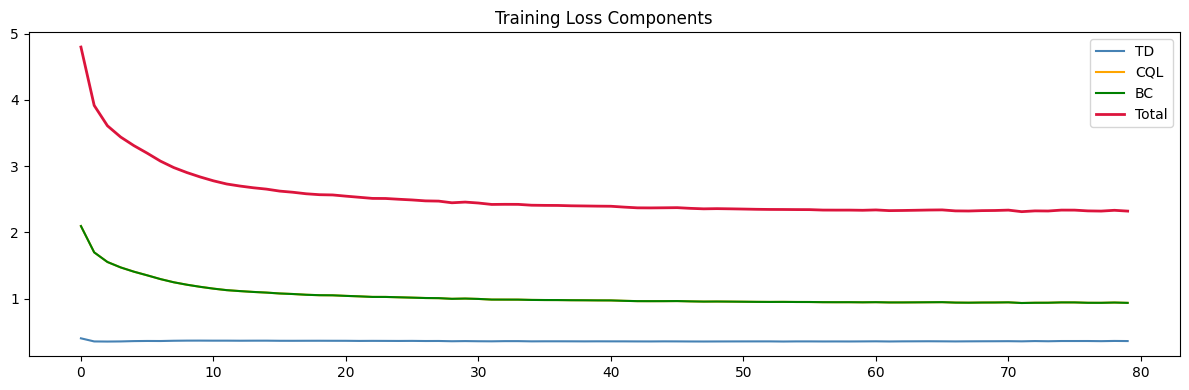

In [6]:
# =========================================================
# CELL 6: Training — DDQN + CQL + BC (with Q-clipping)
# =========================================================
history = {"td":[],"cql":[],"bc":[],"total":[]}
print("Starting training...")

for epoch in range(1, N_EPOCHS + 1):
    q.train()
    ep_td = ep_cql = ep_bc = ep_tot = 0.

    for s, a, r, s2, d in train_loader:
        s, a, r, s2, d = (t.to(DEVICE) for t in (s, a, r, s2, d))

        with torch.no_grad():
            next_a   = q(s2).argmax(1, keepdim=True)
            next_q   = q_tgt(s2).gather(1, next_a).squeeze(1)
            next_q   = torch.clamp(next_q, -Q_CLIP, Q_CLIP)   # ← clip target Q
            targets  = r + GAMMA * (1. - d) * next_q

        q_all = q(s)
        q_all = torch.clamp(q_all, -Q_CLIP, Q_CLIP)           # ← clip predicted Q
        q_sa  = q_all.gather(1, a.view(-1,1)).squeeze(1)

        td_loss  = F.smooth_l1_loss(q_sa, targets)
        cql_loss = (torch.logsumexp(q_all, dim=1) - q_sa).mean()
        bc_loss  = F.cross_entropy(q_all, a)

        loss = td_loss + CQL_W * cql_loss + BC_W * bc_loss

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(q.parameters(), 5.)
        opt.step()

        ep_td  += td_loss.item();  ep_cql += cql_loss.item()
        ep_bc  += bc_loss.item();  ep_tot += loss.item()

    scheduler.step()
    with torch.no_grad():
        for p, pt in zip(q.parameters(), q_tgt.parameters()):
            pt.data.mul_(1. - TAU).add_(TAU * p.data)

    n = len(train_loader)
    history["td"].append(ep_td/n); history["cql"].append(ep_cql/n)
    history["bc"].append(ep_bc/n); history["total"].append(ep_tot/n)

    if epoch % 10 == 0:
        lr_now = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch:3d} | Total={ep_tot/n:.4f}  TD={ep_td/n:.4f}  "
              f"CQL={ep_cql/n:.4f}  BC={ep_bc/n:.4f}  LR={lr_now:.2e}")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(history["td"],    label="TD",    color="steelblue")
ax.plot(history["cql"],   label="CQL",   color="orange")
ax.plot(history["bc"],    label="BC",    color="green")
ax.plot(history["total"], label="Total", color="crimson", linewidth=2)
ax.set_title("Training Loss Components"); ax.legend()
plt.tight_layout(); plt.show()


Test transitions:             67,967
Exact agreement rate:         84.40%
Soft agreement (±1 bin):      93.24%
Avg clinician Q (normalised): 0.4632
Avg AI Q (normalised):        0.6628
Avg expected gain (norm):     0.1997
Avg clinician Q (raw scale):  -1.1063
Avg AI Q (raw scale):         -0.9121


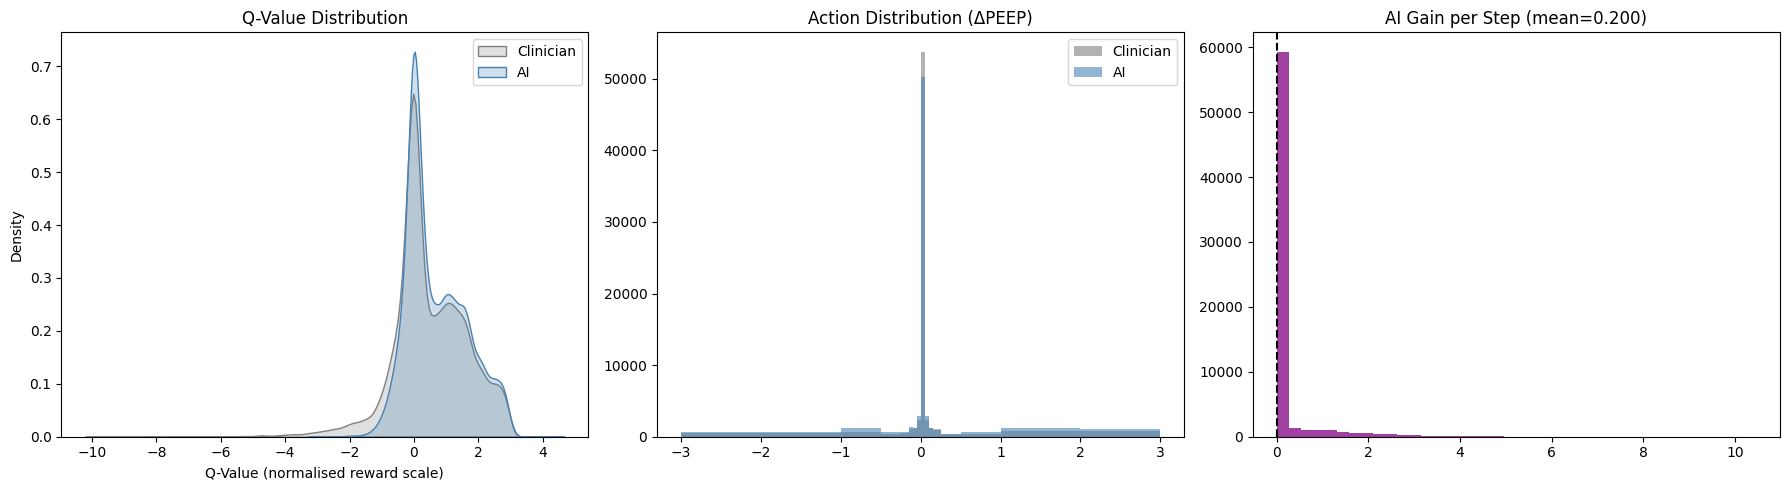

In [7]:
# =========================================================
# CELL 7: Core Evaluation
# =========================================================
q.eval()
with torch.no_grad():
    S_test_t = torch.tensor(S_test, dtype=torch.float32).to(DEVICE)
    q_vals   = q(S_test_t).cpu().numpy()

ai_idx        = np.argmax(q_vals, axis=1)
clinician_idx = A[test_idx]
v_ai          = np.max(q_vals, axis=1)
v_clinician   = q_vals[np.arange(len(q_vals)), clinician_idx]
exp_gain      = (v_ai - v_clinician).mean()

# De-normalise Q-values for human-readable reporting
v_ai_raw      = v_ai      * R_STD + R_MEAN
v_clin_raw    = v_clinician * R_STD + R_MEAN

print("=" * 55)
print(f"Test transitions:             {len(test_idx):,}")
print(f"Exact agreement rate:         {(ai_idx==clinician_idx).mean():.2%}")
print(f"Soft agreement (±1 bin):      {(np.abs(ai_idx-clinician_idx)<=1).mean():.2%}")
print(f"Avg clinician Q (normalised): {v_clinician.mean():.4f}")
print(f"Avg AI Q (normalised):        {v_ai.mean():.4f}")
print(f"Avg expected gain (norm):     {exp_gain:.4f}")
print(f"Avg clinician Q (raw scale):  {v_clin_raw.mean():.4f}")
print(f"Avg AI Q (raw scale):         {v_ai_raw.mean():.4f}")
print("=" * 55)

fig, axes = plt.subplots(1,3,figsize=(18,5))
sns.kdeplot(v_clinician, fill=True, label="Clinician", color="gray",      ax=axes[0])
sns.kdeplot(v_ai,        fill=True, label="AI",        color="steelblue", ax=axes[0])
axes[0].set_title("Q-Value Distribution"); axes[0].legend()
axes[0].set_xlabel("Q-Value (normalised reward scale)")

axes[1].hist(ACTION_VALUES[clinician_idx], bins=ACTION_VALUES, alpha=0.6, label="Clinician", color="gray")
axes[1].hist(ACTION_VALUES[ai_idx],        bins=ACTION_VALUES, alpha=0.6, label="AI",        color="steelblue")
axes[1].set_title("Action Distribution (ΔPEEP)"); axes[1].legend()

gain = v_ai - v_clinician
axes[2].hist(gain, bins=40, color="purple", alpha=0.75)
axes[2].axvline(0, color="black", linestyle="--")
axes[2].set_title(f"AI Gain per Step (mean={exp_gain:.3f})")
plt.tight_layout(); plt.show()


Per-Severity Subgroup Results:
     dp_severity     n  exact_%  soft_%  mean_gain
    Normal (≤14) 22033     90.4    94.2   0.143548
Elevated (14–20) 10160     84.8    92.4   0.218443
    High (20–30) 18745     81.6    93.2   0.223230
  Critical (>30) 11849     75.3    92.5   0.271562


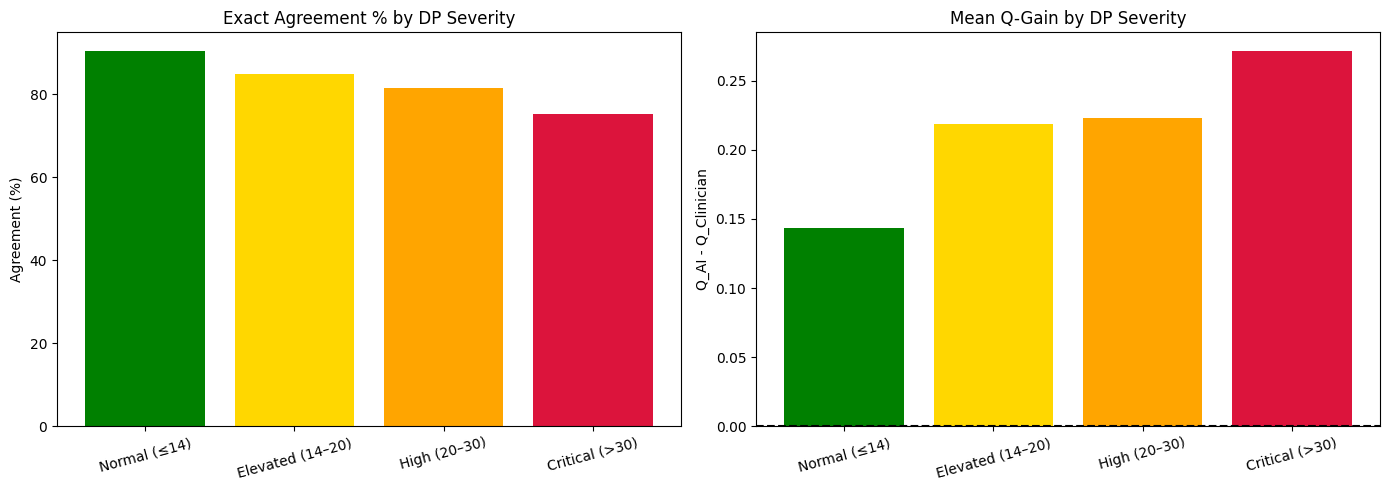

In [8]:
# =========================================================
# CELL 8: Per-Severity Subgroup Analysis
# =========================================================
rl_test = rl.iloc[test_idx].copy().reset_index(drop=True)
rl_test["ai_idx"]      = ai_idx
rl_test["clin_idx"]    = clinician_idx
rl_test["ai_agrees"]   = (ai_idx == clinician_idx)
rl_test["q_gain"]      = v_ai - v_clinician

dp_bins   = [0, 14, 20, 30, 60]
dp_labels = ["Normal (≤14)","Elevated (14–20)","High (20–30)","Critical (>30)"]
rl_test["dp_severity"] = pd.cut(rl_test["dp_dyn"], bins=dp_bins, labels=dp_labels)

subgroup = rl_test.groupby("dp_severity", observed=True).agg(
    n         = ("ai_agrees","count"),
    exact_agr = ("ai_agrees","mean"),
    soft_agr  = ("ai_agrees", lambda x: (
                    np.abs(rl_test.loc[x.index,"ai_idx"] -
                           rl_test.loc[x.index,"clin_idx"]) <= 1).mean()),
    mean_gain = ("q_gain","mean"),
).reset_index()
subgroup["exact_%"] = (subgroup["exact_agr"]*100).round(1)
subgroup["soft_%"]  = (subgroup["soft_agr"] *100).round(1)
print("Per-Severity Subgroup Results:")
print(subgroup[["dp_severity","n","exact_%","soft_%","mean_gain"]].to_string(index=False))

colors = ["green","gold","orange","crimson"]
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].bar(subgroup["dp_severity"], subgroup["exact_%"], color=colors)
axes[0].set_title("Exact Agreement % by DP Severity")
axes[0].set_ylabel("Agreement (%)"); axes[0].tick_params(axis="x",rotation=15)

axes[1].bar(subgroup["dp_severity"], subgroup["mean_gain"], color=colors)
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("Mean Q-Gain by DP Severity")
axes[1].set_ylabel("Q_AI - Q_Clinician"); axes[1].tick_params(axis="x",rotation=15)
plt.tight_layout(); plt.show()


Step importance weight diagnostics (before trajectory product):
  Raw      — mean: 7.098  median: 1.254  p95: 36.436  max: 173.6
  Clipped  — mean: 1.845  % at ceiling: 17.9%
  → If >30% at ceiling, the AI policy is still too divergent from clinicians.
  → If median raw weight <0.1, agreement is low and PDIS will be noisy.

Clipped PDIS  (MAX_WEIGHT=5.0)
  Clinician PDIS return:    0.7543
  AI PDIS return:           -3.7763
  PDIS gain:                -4.5306
  Q-value gain (reference): 0.1997
⚠ PDIS/Q ratio = 22.7x — Q is still overestimating. Consider CQL_W > 2.0.


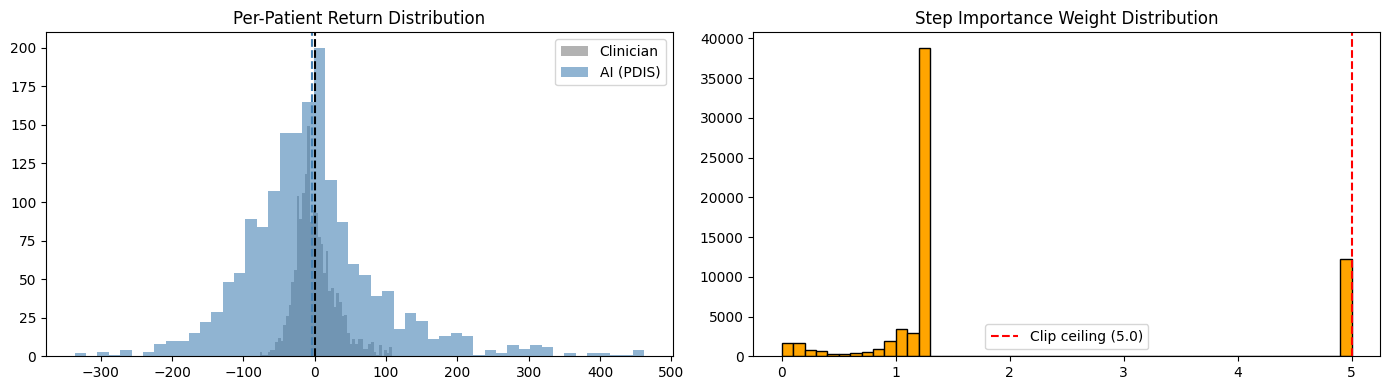

In [9]:
# =========================================================
# CELL 9: Clipped PDIS — with Weight Diagnostics
# =========================================================
# New: print weight distribution stats BEFORE computing PDIS.
# If >50% of weights are hitting the MAX_WEIGHT ceiling, tighten to 2.0.
# If weights are tiny (median <0.01), the policies are still too divergent.
MAX_WEIGHT = 5.0
GAMMA_OPE  = 0.99

q.eval()
with torch.no_grad():
    pi_eval = F.softmax(
        q(torch.tensor(S_test, dtype=torch.float32).to(DEVICE)), dim=1
    ).cpu().numpy()

a_counts    = np.bincount(A[train_idx], minlength=N_ACTIONS).astype(float)
pi_behavior = a_counts / a_counts.sum()

# Per-step weight diagnostic
step_weights_raw = pi_eval[np.arange(len(test_idx)), clinician_idx] / \
                   (pi_behavior[clinician_idx] + 1e-8)
step_weights_clipped = np.clip(step_weights_raw, 0., MAX_WEIGHT)
print(f"Step importance weight diagnostics (before trajectory product):")
print(f"  Raw      — mean: {step_weights_raw.mean():.3f}  median: {np.median(step_weights_raw):.3f}  "
      f"p95: {np.percentile(step_weights_raw,95):.3f}  max: {step_weights_raw.max():.1f}")
print(f"  Clipped  — mean: {step_weights_clipped.mean():.3f}  "
      f"% at ceiling: {(step_weights_raw >= MAX_WEIGHT).mean():.1%}")
print(f"  → If >30% at ceiling, the AI policy is still too divergent from clinicians.")
print(f"  → If median raw weight <0.1, agreement is low and PDIS will be noisy.")

# Clipped per-decision IS by trajectory
test_r   = R[test_idx]          # normalised rewards
test_d   = D[test_idx]
test_vis = rl.iloc[test_idx]["visit_occurrence_id"].values

def run_pdis(test_vis, test_r, test_d, clinician_idx, pi_eval, pi_behavior,
             max_w=MAX_WEIGHT, gamma=GAMMA_OPE):
    patients = {}
    for i, vis in enumerate(test_vis):
        patients.setdefault(vis, []).append(i)

    ai_rets, clin_rets = [], []
    for vis, idxs in patients.items():
        cum_w = 1.
        ep_ai = ep_clin = 0.
        for t, i in enumerate(idxs):
            a_i  = clinician_idx[i]
            pi_a = pi_eval[i, a_i]
            pb_a = pi_behavior[a_i]
            sw   = np.clip(pi_a / (pb_a + 1e-8), 0., max_w)
            cum_w = np.clip(cum_w * sw, 0., max_w)
            g    = gamma ** t
            ep_ai   += g * cum_w * test_r[i]
            ep_clin += g * test_r[i]
        ai_rets.append(ep_ai); clin_rets.append(ep_clin)
    return np.array(ai_rets), np.array(clin_rets)

ai_rets, clin_rets = run_pdis(test_vis, test_r, test_d, clinician_idx, pi_eval, pi_behavior)

pdis_ai   = ai_rets.mean()
pdis_clin = clin_rets.mean()
pdis_gain = pdis_ai - pdis_clin

print(f"\n{'='*55}")
print(f"Clipped PDIS  (MAX_WEIGHT={MAX_WEIGHT})")
print(f"  Clinician PDIS return:    {pdis_clin:.4f}")
print(f"  AI PDIS return:           {pdis_ai:.4f}")
print(f"  PDIS gain:                {pdis_gain:.4f}")
print(f"  Q-value gain (reference): {exp_gain:.4f}")
print(f"{'='*55}")
ratio = abs(pdis_gain) / (abs(exp_gain) + 1e-8)
if ratio < 5:
    print("✓ PDIS and Q-gain are in the same ballpark — Q estimates are plausible.")
else:
    print(f"⚠ PDIS/Q ratio = {ratio:.1f}x — Q is still overestimating. Consider CQL_W > 2.0.")

# Plot
fig, axes = plt.subplots(1,2,figsize=(14,4))
axes[0].hist(clin_rets, bins=50, alpha=0.6, label="Clinician", color="gray")
axes[0].hist(ai_rets,   bins=50, alpha=0.6, label="AI (PDIS)", color="steelblue")
axes[0].axvline(pdis_clin, color="black",     linestyle="--")
axes[0].axvline(pdis_ai,   color="steelblue", linestyle="--")
axes[0].set_title("Per-Patient Return Distribution"); axes[0].legend()

axes[1].hist(step_weights_clipped, bins=50, color="orange", edgecolor="black")
axes[1].axvline(MAX_WEIGHT, color="red", linestyle="--", label=f"Clip ceiling ({MAX_WEIGHT})")
axes[1].set_title("Step Importance Weight Distribution"); axes[1].legend()
plt.tight_layout(); plt.show()



Per-Severity PDIS Results:
        Severity  N transitions  N patients  Clinician PDIS  AI PDIS  PDIS gain
    Normal (≤14)          22033         800       11.298000   30.018     18.719
Elevated (14–20)          10160         384       22.792999   70.405     47.612
    High (20–30)          18745         582      -12.986000  -46.224    -33.238
  Critical (>30)          11849         304      -19.980000  -72.046    -52.066


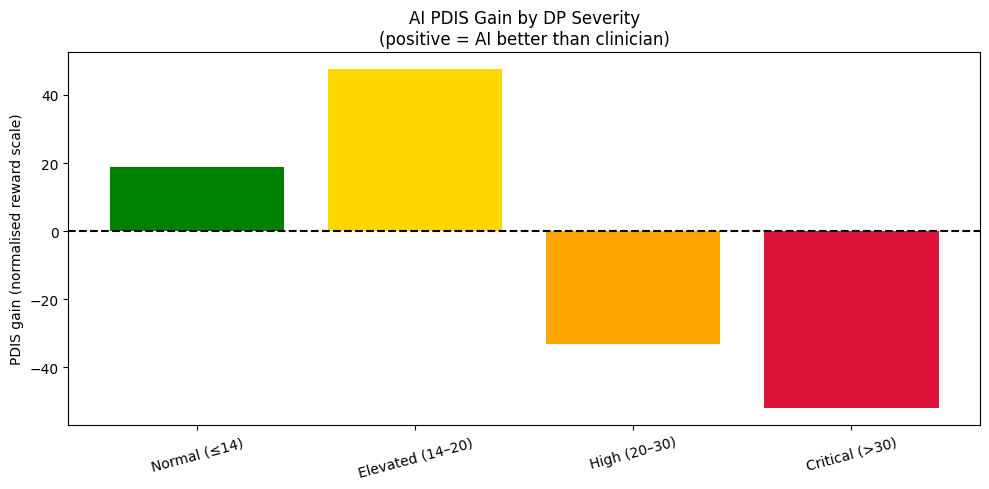

In [10]:
# =========================================================
# CELL 10: Per-Severity PDIS
# =========================================================
# Runs PDIS separately for each DP severity group.
# Critical patients are the most important — this shows if the AI
# genuinely helps where it counts, vs just scoring well on easy cases.

dp_bins_ope   = [0, 14, 20, 30, 60]
dp_labels_ope = ["Normal (≤14)","Elevated (14–20)","High (20–30)","Critical (>30)"]

rl_test_dp = rl.iloc[test_idx].copy().reset_index(drop=True)
rl_test_dp["dp_severity"] = pd.cut(
    rl_test_dp["dp_dyn"], bins=dp_bins_ope, labels=dp_labels_ope)

results = []
for label in dp_labels_ope:
    mask = (rl_test_dp["dp_severity"] == label).values
    if mask.sum() < 10:
        continue
    sub_vis  = test_vis[mask]
    sub_r    = test_r[mask]
    sub_d    = test_d[mask]
    sub_clin = clinician_idx[mask]
    sub_pi   = pi_eval[mask]

    ai_r, cl_r = run_pdis(sub_vis, sub_r, sub_d, sub_clin, sub_pi, pi_behavior)
    results.append({
        "Severity": label,
        "N transitions": mask.sum(),
        "N patients": len(set(sub_vis)),
        "Clinician PDIS": round(cl_r.mean(), 3),
        "AI PDIS": round(ai_r.mean(), 3),
        "PDIS gain": round(ai_r.mean() - cl_r.mean(), 3),
    })

pdis_df = pd.DataFrame(results)
print("\nPer-Severity PDIS Results:")
print(pdis_df.to_string(index=False))

colors = ["green","gold","orange","crimson"][:len(pdis_df)]
plt.figure(figsize=(10,5))
bars = plt.bar(pdis_df["Severity"], pdis_df["PDIS gain"], color=colors)
plt.axhline(0, color="black", linestyle="--")
plt.title("AI PDIS Gain by DP Severity\n(positive = AI better than clinician)")
plt.ylabel("PDIS gain (normalised reward scale)")
plt.xticks(rotation=15); plt.tight_layout(); plt.show()


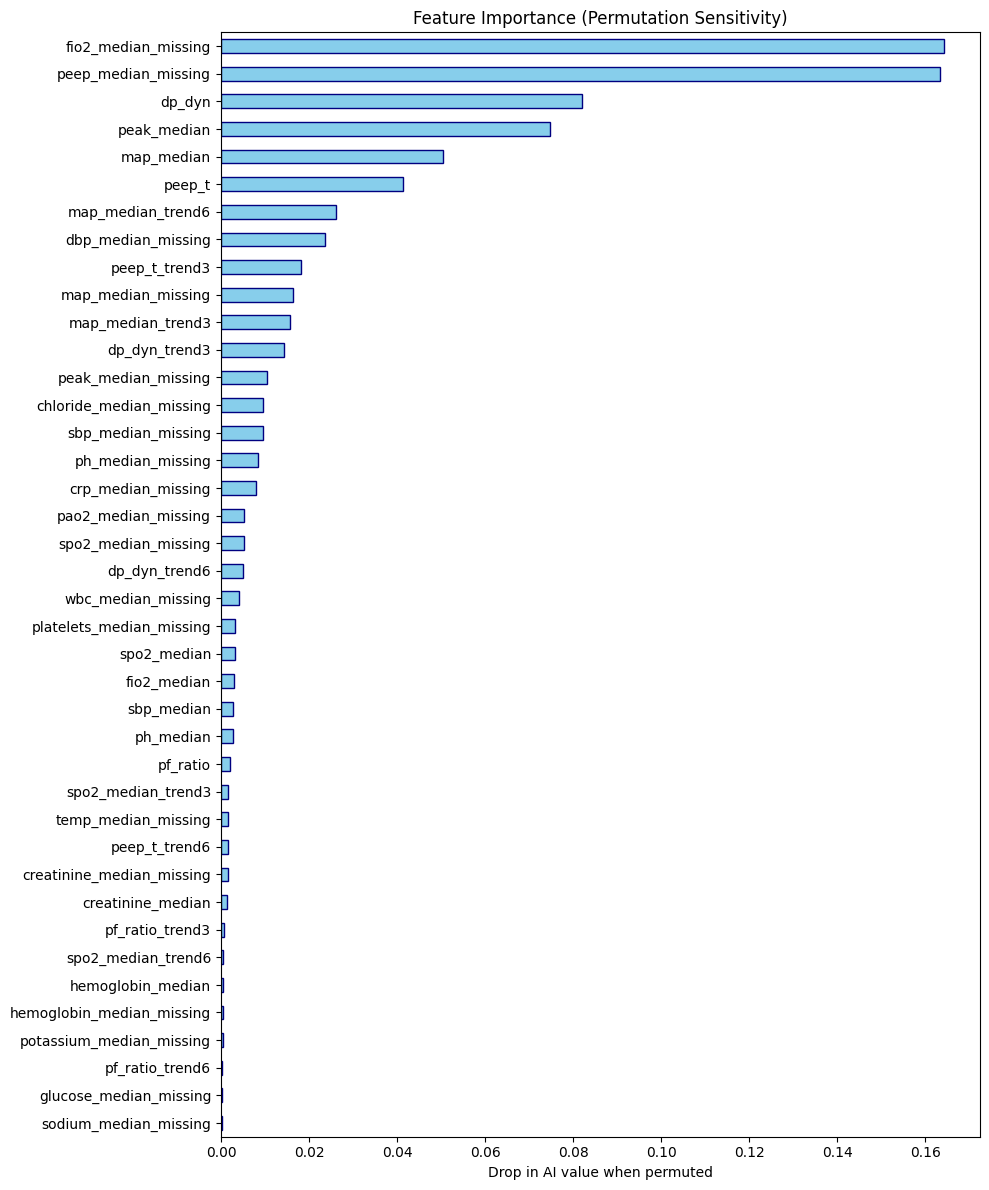


Top 10 most important features:
  fio2_median_missing                    0.16425
  peep_median_missing                    0.16346
  dp_dyn                                 0.08211
  peak_median                            0.07475
  map_median                             0.05042
  peep_t                                 0.04146
  map_median_trend6                      0.02620
  dbp_median_missing                     0.02375
  peep_t_trend3                          0.01821
  map_median_missing                     0.01634


In [11]:
# =========================================================
# CELL 11: Feature Importance
# =========================================================
rng = np.random.default_rng(SEED)
q.eval()
with torch.no_grad():
    base_val = q(torch.tensor(S_test, dtype=torch.float32).to(DEVICE)).max(1)[0].mean().item()

importances = {}
for i, col in enumerate(obs_cols):
    S_p = S_test.copy(); rng.shuffle(S_p[:, i])
    with torch.no_grad():
        pv = q(torch.tensor(S_p, dtype=torch.float32).to(DEVICE)).max(1)[0].mean().item()
    importances[col] = abs(base_val - pv)

imp = pd.Series(importances).sort_values(ascending=True)
plt.figure(figsize=(10, max(6, len(obs_cols)*0.3)))
imp.plot(kind="barh", color="skyblue", edgecolor="navy")
plt.title("Feature Importance (Permutation Sensitivity)")
plt.xlabel("Drop in AI value when permuted")
plt.tight_layout(); plt.show()

print("\nTop 10 most important features:")
for feat, val in imp.sort_values(ascending=False).head(10).items():
    print(f"  {feat:<38} {val:.5f}")


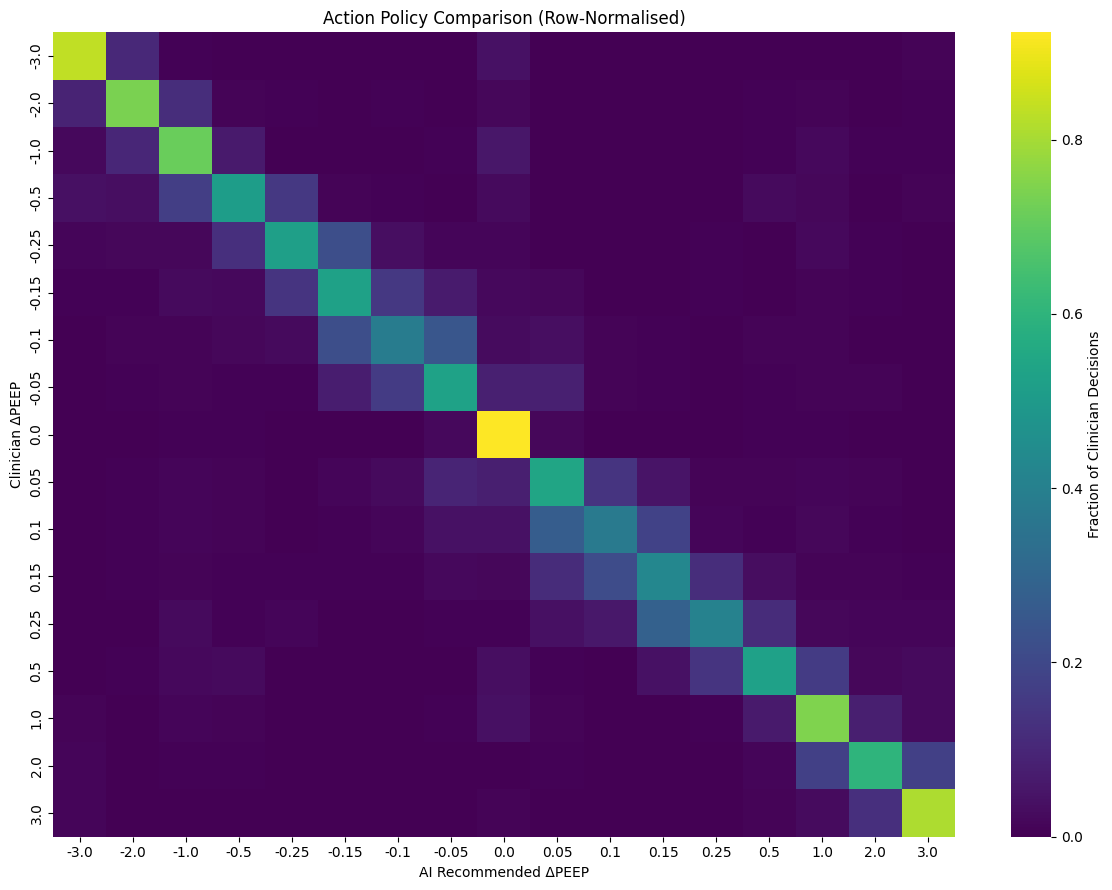

Saved 67,967 rows to ai_peep_recommendations_v4.csv
   visit_occurrence_id  measure_time  current_peep  current_dp  clinician_delta  ai_recommended_delta  ai_recommended_total_peep  ai_agrees_with_clinician  uncertainty_entropy  expected_return_norm  expected_return_raw
0                   44             0          5.90       34.10             0.00                  0.00                       5.90                         1               1.3432                0.2482              -1.3154
1                   44             1          5.60       34.40            -0.25                 -0.25                       5.35                         1               1.1877                0.1979              -1.3643
2                   44             2          6.60       33.40             1.00                  1.00                       7.60                         1               2.4074                0.4022              -1.1656
3                   44             3          6.60       33.40          

In [12]:
# =========================================================
# CELL 12: Action Heatmap + Export
# =========================================================
from sklearn.metrics import confusion_matrix

cm      = confusion_matrix(clinician_idx, ai_idx, labels=list(range(N_ACTIONS)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)
plt.figure(figsize=(12,9))
sns.heatmap(cm_norm, cmap="viridis",
            xticklabels=np.round(ACTION_VALUES,2),
            yticklabels=np.round(ACTION_VALUES,2),
            cbar_kws={"label":"Fraction of Clinician Decisions"})
plt.title("Action Policy Comparison (Row-Normalised)")
plt.xlabel("AI Recommended ΔPEEP"); plt.ylabel("Clinician ΔPEEP")
plt.tight_layout(); plt.show()

# Export
q.eval()
with torch.no_grad():
    q_out    = q(torch.tensor(S_test, dtype=torch.float32).to(DEVICE))
    best_idx = q_out.argmax(dim=1).cpu().numpy()
    probs    = F.softmax(q_out, dim=1).cpu().numpy()
    entropy  = -np.sum(probs * np.log(probs + 1e-9), axis=1)
    exp_ret  = q_out.max(dim=1).values.cpu().numpy()

test_df   = rl.iloc[test_idx].copy().reset_index(drop=True)
rec_delta = ACTION_VALUES[best_idx]
export_df = pd.DataFrame({
    "visit_occurrence_id":       test_df["visit_occurrence_id"],
    "measure_time":              test_df["measure_time"],
    "current_peep":              test_df["peep_t"],
    "current_dp":                test_df["dp_dyn"],
    "clinician_delta":           ACTION_VALUES[clinician_idx],
    "ai_recommended_delta":      rec_delta,
    "ai_recommended_total_peep": (test_df["peep_t"] + rec_delta).clip(lower=0.),
    "ai_agrees_with_clinician":  (best_idx == clinician_idx).astype(int),
    "uncertainty_entropy":       np.round(entropy, 4),
    "expected_return_norm":      np.round(exp_ret, 4),
    "expected_return_raw":       np.round(exp_ret * R_STD + R_MEAN, 4),
})
export_df.to_csv("ai_peep_recommendations_v4.csv", index=False)
print(f"Saved {len(export_df):,} rows to ai_peep_recommendations_v4.csv")
print(export_df.head(8).to_string())
